<a href="https://colab.research.google.com/github/Franklinyeruan/CHEM101.6/blob/main/Wk1_Basic_Alkanes_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Week 1 Project: Basic Alkanes Simulation!** <Br>
Author: Franklin Ruan, 5 Jan 2022, 22W, CHEM 96   <Br>
Program for basic alkane simulation - adapted from: <Br> 
1. https://education.molssi.org/mm-tools/
2. https://colab.research.google.com/github/paulrobustelli/CHEM101.6/blob/main/Butane_OpenMM.ipynb


---


---






In [34]:
# @title Connect to Cloud GPU 
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun Jan  9 21:37:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    36W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Molecular Mechanics Tools: Setup
Guide for installing openmm on Google Colab: <br> https://github.com/molmod/openmm-tutorial-msbs/blob/master/setup_on_google_colab.md 

In [ ]:
import sys
print(sys.version)
!wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.10.3-Linux-x86_64.sh
!bash Miniconda3-py*.sh -bfp /usr/local
!conda config --set always_yes yes
!conda config --add channels conda-forge
!conda create -n openmm python=3.7 cudatoolkit=10.0 git jupyterlab numpy pandas scipy matplotlib ipympl rdkit openbabel openmm mdtraj pymbar pdbfixer parmed openff-toolkit openmoltools openmmforcefields
sys.path.append('/usr/local/envs/openmm/lib/python3.7/site-packages')
import openmm.testInstallation
openmm.testInstallation.main()

VS Code will be used as a text editor 

**Install dependencies** <br>
It will take a few minutes, please wait :) 

In [ ]:
# install dependencies
!pip -q install py3Dmol 2>&1 1>/dev/null
!pip install --upgrade MDAnalysis 2>&1 1>/dev/null
!pip install biopandas 2>&1 1>/dev/null
# install conda
!wget -qnc https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh 
!bash Miniconda3-latest-Linux-x86_64.sh -bfp /usr/local 2>&1 1>/dev/null
!rm Miniconda3-latest-Linux-x86_64.sh
!conda install -y -q -c conda-forge openmm=7.6 python=3.7 pdbfixer 2>&1 1>/dev/null
!conda install -c conda-forge ambertools --yes 2>&1 1>/dev/null
!conda install -c ambermd pytraj  --yes 2>&1 1>/dev/null
#load dependencies
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
from biopandas.pdb import PandasPdb
import openmm as mm
from openmm import *
from openmm.app import *
from openmm.unit import *
import os
import urllib.request  
import numpy as np
import MDAnalysis as mda
import py3Dmol
from __future__ import print_function
import pytraj as pt
import platform
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
import seaborn as sb
from statistics import mean, stdev
from pytraj import matrix
from matplotlib import colors
from IPython.display import set_matplotlib_formats

#Introduction

Computational Chemistry is a field which uses calculations perfomed on computers to predict real world properties of molecules. Though, percise quantum mechanics can be calculculated, it is often taxing; thus, the braod category of computational chemistry is based off classical Newtonian physics. 

The full expression of a mathematical model for a molecule is often called a force field. 

**Do not run bottom code** 
Below is the XML file for butane describing it's force field  

In [ ]:
<ForceField>
 <AtomTypes>
  <Type name="0" class="c3" element="C" mass="12.01078"/>
  <Type name="1" class="c3" element="C" mass="12.01078"/>
  <Type name="2" class="hc" element="H" mass="1.007947"/>
  <Type name="3" class="hc" element="H" mass="1.007947"/>
 </AtomTypes>
 <Residues>
  <Residue name="NBU">
   <Atom name="C1" type="0"/>
   <Atom name="H11" type="2"/>
   <Atom name="H12" type="2"/>
   <Atom name="H13" type="2"/>
   <Atom name="C2" type="1"/>
   <Atom name="H21" type="3"/>
   <Atom name="H22" type="3"/>
   <Atom name="C3" type="1"/>
   <Atom name="H31" type="3"/>
   <Atom name="H32" type="3"/>
   <Atom name="C4" type="0"/>
   <Atom name="H41" type="2"/>
   <Atom name="H42" type="2"/>
   <Atom name="H43" type="2"/>

   # TODO: ***FILL IN THE TOPOLOGY***
   #Carbon 1
   <Bond atomName1="C1" atomName2="H11"/>
   <Bond atomName1="C1" atomName2="H12"/>
   <Bond atomName1="C1" atomName2="H13"/>
   <Bond atomName1="C1" atomName2="C1"/>

   #Carbon 2
   <Bond atomName1="C2" atomName2="H21"/>
   <Bond atomName1="C2" atomName2="H22"/>
   <Bond atomName1="C2" atomName2="C3"/>

   #Carbon 3
   <Bond atomName1="C3" atomName2="H31"/>
   <Bond atomName1="C3" atomName2="H32"/>
   <Bond atomName1="C3" atomName2="C4"/>

   #Carbon 4
   <Bond atomName1="C4" atomName2="H41"/>
   <Bond atomName1="C4" atomName2="H42"/>
   <Bond atomName1="C4" atomName2="H43"/>
   
  </Residue>
 </Residues>
 <HarmonicBondForce>
  # TODO: ***FILL IN THE BOND PARAMETERS***
  <Bond class1="c3" class2="c3" length="0.15380" k="1945727.36"/>
  <Bond class1="c3" class2="hc" length="0.10970" k="3145687.56"/>

 </HarmonicBondForce>
 <HarmonicAngleForce>
  # TODO: ***FILL IN THE ANGLE PARAMETERS***
  <Angle class1="c3" class2="c3" class3="c3" angle="1.94621665" k="542.982784"/>
  <Angle class1="c3" class2="c3" class3="hc" angle="1.91637152" k="391.756288"/>
  <Angle class1="hc" class2="c3" class3="hc" angle="1.87762521" k="326.01728"/>
 </HarmonicAngleForce>
 <PeriodicTorsionForce>
  # TODO: ***FILL IN THE TORSION PARAMETERS***
  <Proper class1="c3" class2="c3" class3="c3" class4="c3" periodicity1="3" phase1="0.0" k1="0.5439" periodicity2="2" phase2="3.1416" k2="1.2134" periodicity3="1" phase3="0.0" k3="0.4602"/>
  <Proper class1="c3" class2="c3" class3="c3" class4="hc" periodicity1="3" phase1="0.0" k1="0.3347"/>
  <Proper class1="hc" class2="c3" class3="c3" class4="hc" periodicity1="3" phase1="0.0" k1="0.50208"/>
 </PeriodicTorsionForce>
 <NonbondedForce coulomb14scale="0.833333" lj14scale="0.5">
  # TODO: ***FILL IN THE NONBONDED PARAMETERS***
  <Atom type="0" charge="-0.0932" sigma="0.3397710" epsilon="0.4510352"/>
  <Atom type="1" charge="-0.0814" sigma="0.3397710" epsilon="0.4510352"/>
  <Atom type="2" charge="0.0324" sigma="0.2600177" epsilon="0.0870272"/>
  <Atom type="3" charge="0.0387" sigma="0.2600177" epsilon="0.0870272"/>
 </NonbondedForce>
</ForceField>

#MD Simulation of Alkanes

Molecular dynamics simulates molcules in time by calculating the forces on atoms and updating their positions based on those forces. 

You have atoms with initial positoins and velocities at time=0. You can use these positions to calculate potential energy and the forces on each atom, and generating new positions. Δt=1 femtosecond typically. 

Procedure: 
- **Initialization** - Build the system including the topology (connectivity), forcefield parameters, and setting simulation details such as temperature and integrator.
- **Minimization** - A brief energy minimization to eliminate “bad” interatomic contacts (i.e., ones that would cause high forces) that would result in a numerically unstable simulation.
- **Equilibration** - A brief MD simulation for the purpose of bringing the system temperature or temperature and volume to the desired equilibrium values.
- **Production** - A long MD simulation for the purpose of collecting data.
- **Analysis** - After you have collected your data from the production run, you must analyze the trajectory to draw conclusions.

**BELOW** is the simulation of Butane

**Simulation Initialization**

In [10]:
# Import libraries
from openmm import app
import openmm as mm
from openmm import unit

In [11]:
# Create Forcefields 
pdb = app.PDBFile("/content/drive/MyDrive/School /CHEM 96: Computational Chem /Project 1/data/butane.pdb")
forcefield = app.ForceField("/content/drive/MyDrive/School /CHEM 96: Computational Chem /Project 1/data/butane.gaff2.xml")

In [12]:
# Set up the system for MD simulation
# @params: no cutoff & constrain bonds with hydrogens
system = forcefield.createSystem(pdb.topology, nonbondedMethod=app.NoCutoff, constraints=app.HBonds)

In [13]:
# Integreate Newton's equations of motion
# Using Langevin Integrator, T = 298.15 K, in vacuum
# stochastic integrator with 5.0 picosecond coupling constant
integrator = mm.LangevinIntegrator(298.15*unit.kelvin, 5.0/unit.picoseconds, 2.0*unit.femtoseconds)
integrator.setConstraintTolerance(1e-5)

In [14]:
# Concatenate all the simulation pieces
platform = mm.Platform.getPlatformByName('Reference')
simulation = app.Simulation(pdb.topology, system, integrator, platform)
simulation.context.setPositions(pdb.positions)

**Energy Minimization** 

In [15]:
# Moves aatoms of the molecule slightly to get a local min in energy
print('Minimizing...')

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy before minimization is {st.getPotentialEnergy()}")

simulation.minimizeEnergy(maxIterations=100)

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy after minimization is {st.getPotentialEnergy()}")

Minimizing...
Potential energy before minimization is 5.797528692127868 kJ/mol
Potential energy after minimization is 5.295784483017471 kJ/mol


**Equilibration** 

In [16]:
# Purpose of equilibration is to get system to target temp and ready for production run.
# stdout asks program to print information. 
from sys import stdout

print('Equilibrating...')

simulation.reporters.append(app.StateDataReporter(stdout, 100, step=True, 
    potentialEnergy=True, temperature=True, separator=','))
simulation.context.setVelocitiesToTemperature(150.0*unit.kelvin)
simulation.step(2500)


Equilibrating...
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
100,32.462463170022396,199.50775241096343
200,32.56430680771442,315.2871478384997
300,54.461220389395336,367.1734202473054
400,32.79293723456541,311.07059207838034
500,44.73758293643917,246.90701700862155
600,47.498316783343206,327.3471036214838
700,32.56638939458919,327.8128152922315
800,40.69787114330442,273.55376178627097
900,51.40063436019024,370.23475035816944
1000,38.964995296804524,238.16342312474842
1100,64.25465205896604,248.20943579230016
1200,46.39722026178076,387.22484886538524
1300,46.332899368432436,345.232773073269
1400,44.301177186010676,241.34711283717337
1500,24.395400620912476,376.2802205303724
1600,45.46015273031723,323.85274756480703
1700,41.280118745687375,500.77153936724295
1800,46.723030421422784,335.32840594242566
1900,40.892424015591075,290.48694592505433
2000,34.42507407884489,211.64294707238832
2100,55.697910799737876,167.2817305765803
2200,44.0156646483935,243.33663677585255
2300,44.754

**Production** <br>

out = step number, simulation time, pot energy, temp, and "speed" for steps

"speed" is reported in ns/day or how many nanoseconds would pass for 24 hours of computation time.

In [17]:
# Longer block of simulation
# includes timer 
import time as time

print('Running Production...')

# Begin timer
tinit=time.time()

# Clear simulation reporters
simulation.reporters.clear()

# Reinitialize simulation reporters. We do this because we want different information printed from the production run than the equilibration run.
# output basic simulation information below every 250000 steps - (which is equal to 2 fs(250,000) = 500,000 fs = 500 ps)
simulation.reporters.append(app.StateDataReporter(stdout, 250000, 
    step=True, time=True, potentialEnergy=True, temperature=True, 
    speed=True, separator=','))

# write out a trajectory (i.e., coordinates vs. time) to a DCD
# file every 100 steps - 0.2 ps
simulation.reporters.append(app.DCDReporter('butane_sim.dcd', 100))

# run the simulation for 1.0x10^7 steps - 20 ns
simulation.step(10000000)

# End timer
tfinal=time.time()
print('Done!')
print('Time required for simulation:', tfinal-tinit, 'seconds')

Running Production...
#"Step","Time (ps)","Potential Energy (kJ/mole)","Temperature (K)","Speed (ns/day)"
250000,500.0000000016593,61.93720714888973,406.89137039267194,0
500000,999.9999999901769,27.58345076605716,153.55334316578325,1.18e+04
750000,1499.9999999783536,60.453639937876254,298.2908837930272,1.19e+04
1000000,1999.9999999665301,49.726549487554166,347.7942803354274,1.19e+04
1250000,2499.9999999547067,36.30412051879972,460.2705263609501,1.2e+04
1500000,2999.9999999428833,52.51655877543964,376.0313254609211,1.2e+04
1750000,3499.99999993106,56.470793554828006,204.30532560786324,1.2e+04
2000000,3999.9999999192364,39.61353610334437,307.7588622339719,1.19e+04
2250000,4499.9999999992715,50.77529870766908,309.9043457585715,1.19e+04
2500000,5000.000000101135,22.80447838291741,372.66796296229694,1.19e+04
2750000,5500.000000202998,26.24324990217541,266.10602314981963,1.19e+04
3000000,6000.000000304862,37.374013577025806,372.01516062736295,1.19e+04
3250000,6500.000000406725,41.79871049255

#**Analysis of Ethane** <br> 

In [ ]:
# nglview -> vixualize trajectory
# MDTraj to analyze trajectory
!conda install -c conda-forge mdtraj 

In [19]:
# The command reads all atomic positiosn and keep tracks of atom connectivity (topology)
import mdtraj as md
traj = md.load('/content/drive/MyDrive/School /CHEM 96: Computational Chem /Project 1/data/ethane_sim.dcd', top='/content/drive/MyDrive/School /CHEM 96: Computational Chem /Project 1/data/ethane.pdb')


In [ ]:
!pip install -q nglview pytraj
from google.colab import output
output.enable_custom_widget_manager()

In [20]:
#provides visuals
import nglview as ngl

visualize = ngl.show_mdtraj(traj)
visualize

NGLWidget(max_frame=99999)

In [21]:
# Pull out bonds and atoms for analysis 
# @return: dataframe
atoms, bonds = traj.topology.to_dataframe()
atoms

,serial,name,element,resSeq,resName,chainID,segmentID
0,1,C1,C,1,ETH,0,
1,2,H11,H,1,ETH,0,
2,3,H12,H,1,ETH,0,
3,4,H13,H,1,ETH,0,
4,5,C2,C,1,ETH,0,
5,6,H21,H,1,ETH,0,
6,7,H22,H,1,ETH,0,
7,8,H23,H,1,ETH,0,


Let's decide which atoms from our molecule define bond angle. We have to pick the atom indices for the C-C bond. These are 0 and 4. 

In [22]:
bond_indices = [0, 4] # atoms to define the bond length
bond_length = md.compute_distances(traj, [bond_indices])

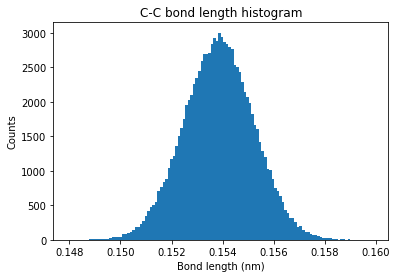

In [23]:
import matplotlib.pyplot as plt

bondcounts, binedges, otherstuff = plt.hist(bond_length, bins=120)
plt.title('C-C bond length histogram')
plt.xlabel('Bond length (nm)')
plt.ylabel('Counts')
plt.show()

[[ 1.2284089 ]
 [ 0.77280563]
 [ 1.2600248 ]
 ...
 [ 1.6507894 ]
 [ 2.3919144 ]
 [-2.9804592 ]]


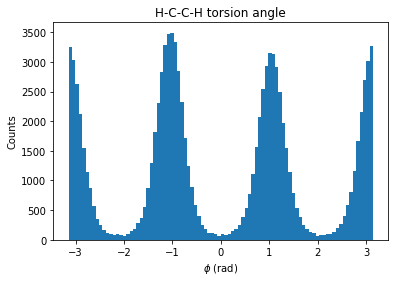

In [24]:
# H-C-C-H torian angle
phi_indices = [1, 0, 4, 5] # atoms to define the torsion angle
phi = md.compute_dihedrals(traj, [phi_indices])

print(phi)

import matplotlib.pyplot as plt

phicounts, binedges, otherstuff = plt.hist(phi, bins=90) # create a histogram with 90 bins
plt.title('H-C-C-H torsion angle')
plt.xlabel(r'$\phi$ (rad)')
plt.ylabel('Counts')
plt.show()

**Potential of Mean Force Calculation** <br>

we have looked at the distribution of bond lengths and torsion angles for ethane. However, we can also use our simulations to calculate thermodynamics properties of our system. For example, we can use our calculated distributions along with Boltzmann’s constant to calculate the potential of mean force (pmf), or energy change associated with changes in the bond length or torsion angle.

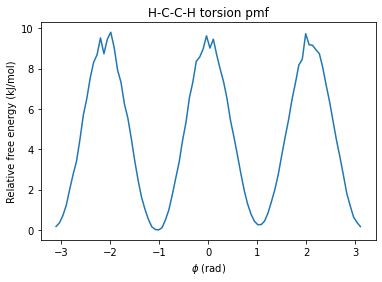

In [26]:
import numpy as np

kB = 8.31446/1000 # Boltzmann constant in kJ/mol
Temp = 298.15 # simulation temperature
phicounts[phicounts==0] = 0.1 # get rid of any bins with 0 counts/infinite energy
pmf = -kB*Temp*np.log(phicounts) # W(x) = -kT*ln[p(x)] = -kT*ln[n(x)] + C
pmf = pmf - np.min(pmf) # subtract off minimum value so that energies start from 0

bincenters = (binedges[1:] + binedges[:-1])/2 # compute centers of histogram bins

plt.plot(bincenters, pmf)
plt.title('H-C-C-H torsion pmf')
plt.xlabel(r'$\phi$ (rad)')
plt.ylabel('Relative free energy (kJ/mol)')
plt.show()

#**Butane Trajectory Analysis**

In [39]:
traj = md.load('/content/drive/MyDrive/School /CHEM 96: Computational Chem /Project 1/data/butane_sim.dcd', top='/content/drive/MyDrive/School /CHEM 96: Computational Chem /Project 1/data/butane.pdb')
atoms, bonds = traj.topology.to_dataframe()
atoms

,serial,name,element,resSeq,resName,chainID,segmentID
0,1,C1,C,1,NBU,0,
1,2,H11,H,1,NBU,0,
2,3,H12,H,1,NBU,0,
3,4,H13,H,1,NBU,0,
4,5,C2,C,1,NBU,0,
5,6,H21,H,1,NBU,0,
6,7,H22,H,1,NBU,0,
7,8,C3,C,1,NBU,0,
8,9,H31,H,1,NBU,0,
9,10,H32,H,1,NBU,0,


In [40]:
visualize = ngl.show_mdtraj(traj)
visualize

NGLWidget(max_frame=99999)

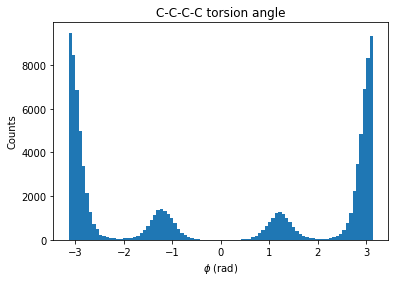

100000.0


In [41]:
# C-C-C-C
phi_indices = [0, 4, 7, 10] # atoms to define the torsion angle
phi = md.compute_dihedrals(traj, [phi_indices])

phicounts, binedges, otherstuff = plt.hist(phi, bins=90) 
plt.title('C-C-C-C torsion angle')
plt.xlabel(r'$\phi$ (rad)')
plt.ylabel('Counts')
plt.show()

print(np.sum(phicounts))


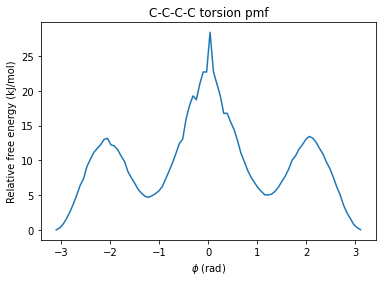

In [42]:
# C-C-C-C torsion PMF
B = 8.31446/1000 # Boltzmann constant in kJ/mol
Temp = 298.15 # simulation temperature in K
phicounts[phicounts==0] = 0.1 # get rid of any bins with 0 counts/infinite energy
pmf = -kB*Temp*np.log(phicounts) # W(x) = -kT*ln[p(x)] = -kT*ln[n(x)] + C
pmf = pmf - np.min(pmf) # subtract off minimum value so that energies start from 0

bincenters = (binedges[1:] + binedges[:-1])/2 # compute centers of histogram bins

plt.plot(bincenters, pmf)
plt.title('C-C-C-C torsion pmf')
plt.xlabel(r'$\phi$ (rad)')
plt.ylabel('Relative free energy (kJ/mol)')
plt.show()

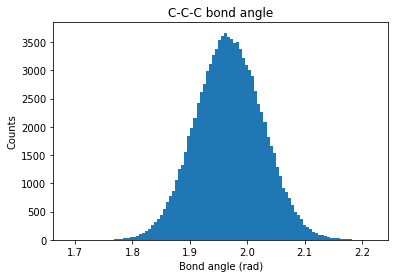

In [43]:
# C-C-C angle
angle_indices = [0, 4, 7] # or could do [4, 7, 10]
bondangle = md.compute_angles(traj, [angle_indices])

anglecounts, binedges, otherstuff = plt.hist(bondangle, bins=100)
plt.title('C-C-C bond angle')
plt.xlabel('Bond angle (rad)')
plt.ylabel('Counts')
plt.show()

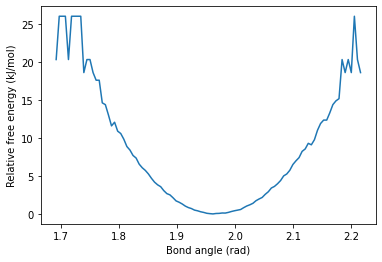

In [44]:
# C-C-C angle PMF
anglecounts[anglecounts==0] = 0.1
pmf = -kB*Temp*np.log(anglecounts)
pmf = pmf - np.min(pmf)

bincenters = (binedges[1:] + binedges[:-1])/2


plt.plot(bincenters, pmf)
plt.xlabel('Bond angle (rad)')
plt.ylabel('Relative free energy (kJ/mol)')
plt.show()

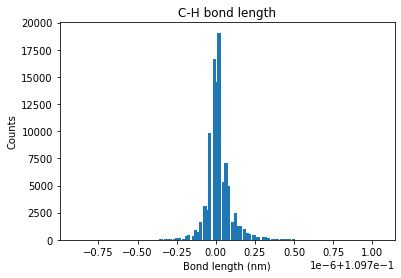

In [45]:
# C-H
bond_indices = [0, 1] # many possibilities!
bondlength = md.compute_distances(traj, [bond_indices])

lengthcounts, binedges, otherstuff = plt.hist(bondlength, bins=100)
plt.title('C-H bond length')
plt.xlabel('Bond length (nm)')
plt.ylabel('Counts')
plt.show()

https://colab.research.google.com/github/paulrobustelli/CHEM101.6/blob/main/Butane_OpenMM.ipynb#scrollTo=wH1oMiVUlxO_ <Br>
Butane Analysis 

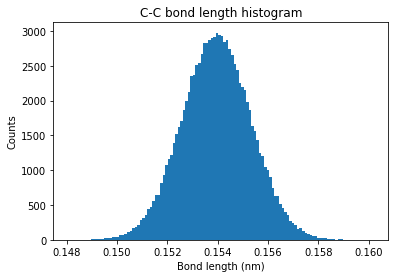

In [46]:
bond_indices = [4, 7] # atoms to define the bond length
bond_length = md.compute_distances(traj, [bond_indices])

bondcounts, binedges, otherstuff = plt.hist(bond_length, bins=120)
plt.title('C-C bond length histogram')
plt.xlabel('Bond length (nm)')
plt.ylabel('Counts')
plt.show()

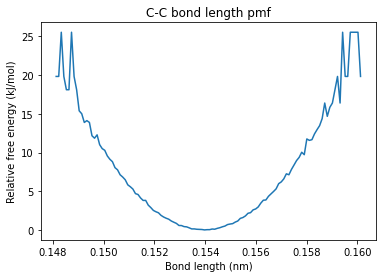

In [47]:
kB = 8.31446/1000 # Boltzmann constant in kJ/mol
Temp = 298.15 # simulation temperature
bondcounts[bondcounts==0] = 0.1 # get rid of any bins with 0 counts/infinite energy
pmf = -kB*Temp*np.log(bondcounts) # W(x) = -kT*ln[p(x)] = -kT*ln[n(x)] + C
pmf = pmf - np.min(pmf) # subtract off minimum value so that energies start from 0

bincenters = (binedges[1:] + binedges[:-1])/2 # compute centers of histogram bins

plt.plot(bincenters, pmf)
plt.xlabel('Bond length (nm)')
plt.ylabel('Relative free energy (kJ/mol)')
plt.title('C-C bond length pmf')
plt.show()

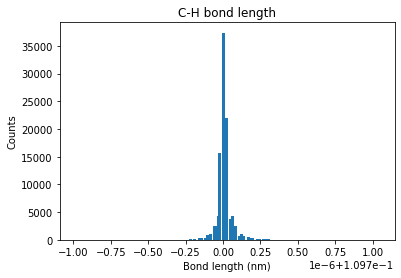

In [48]:
bond_indices = [4, 5] # many possibilities!
bondlength = md.compute_distances(traj, [bond_indices])

lengthcounts, binedges, otherstuff = plt.hist(bondlength, bins=100)
plt.title('C-H bond length')
plt.xlabel('Bond length (nm)')
plt.ylabel('Counts')
plt.show()

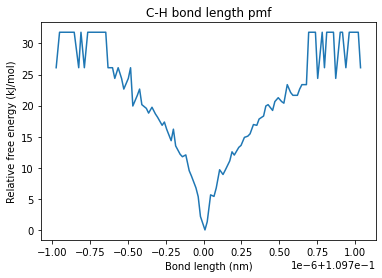

In [49]:
kB = 8.31446/1000 # Boltzmann constant in kJ/mol
Temp = 298.15 # simulation temperature
lengthcounts[lengthcounts==0] = 0.1 # get rid of any bins with 0 counts/infinite energy
pmf = -kB*Temp*np.log(lengthcounts) # W(x) = -kT*ln[p(x)] = -kT*ln[n(x)] + C
pmf = pmf - np.min(pmf) # subtract off minimum value so that energies start from 0

bincenters = (binedges[1:] + binedges[:-1])/2 # compute centers of histogram bins

plt.plot(bincenters, pmf)
plt.xlabel('Bond length (nm)')
plt.ylabel('Relative free energy (kJ/mol)')
plt.title('C-H bond length pmf')
plt.show()

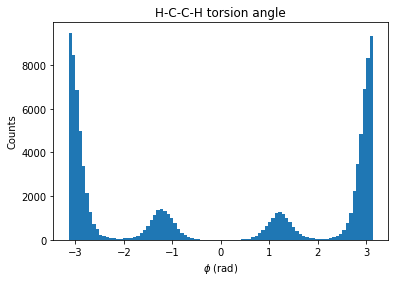

In [50]:
phi_indices = [0, 4, 7, 10] # atoms to define the torsion angle
phi = md.compute_dihedrals(traj, [phi_indices])

phicounts, binedges, otherstuff = plt.hist(phi, bins=90) # create a histogram with 90 bins
plt.title('H-C-C-H torsion angle')
plt.xlabel(r'$\phi$ (rad)')
plt.ylabel('Counts')
plt.show()

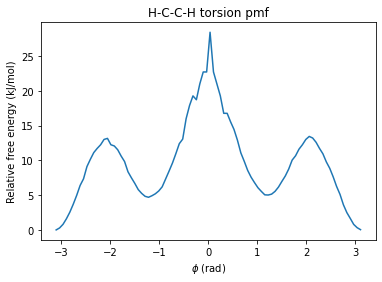

In [51]:
kB = 8.31446/1000 # Boltzmann constant in kJ/mol
Temp = 298.15 # simulation temperature
phicounts[phicounts==0] = 0.1 # get rid of any bins with 0 counts/infinite energy
pmf = -kB*Temp*np.log(phicounts) # W(x) = -kT*ln[p(x)] = -kT*ln[n(x)] + C
pmf = pmf - np.min(pmf) # subtract off minimum value so that energies start from 0

bincenters = (binedges[1:] + binedges[:-1])/2 # compute centers of histogram bins

plt.plot(bincenters, pmf)
plt.title('H-C-C-H torsion pmf')
plt.xlabel(r'$\phi$ (rad)')
plt.ylabel('Relative free energy (kJ/mol)')
plt.show()

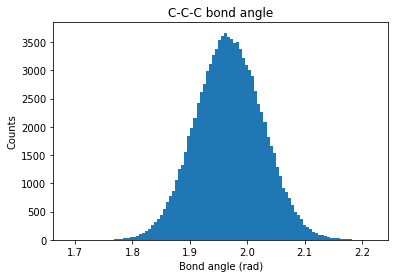

In [52]:
angle_indices = [0, 4, 7] # or could do [4, 7, 10]
bondangle = md.compute_angles(traj, [angle_indices])

anglecounts, binedges, otherstuff = plt.hist(bondangle, bins=100)
plt.title('C-C-C bond angle')
plt.xlabel('Bond angle (rad)')
plt.ylabel('Counts')
plt.show()

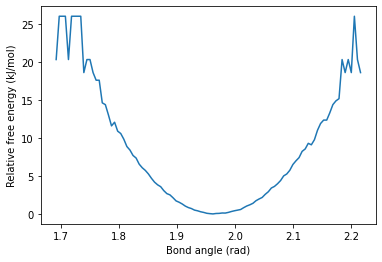

In [53]:
anglecounts[anglecounts==0] = 0.1
pmf = -kB*Temp*np.log(anglecounts)
pmf = pmf - np.min(pmf)

bincenters = (binedges[1:] + binedges[:-1])/2


plt.plot(bincenters, pmf)
plt.xlabel('Bond angle (rad)')
plt.ylabel('Relative free energy (kJ/mol)')
plt.show()